# <center>Advanced Machine Learning, Spring 2023</center>
### <center>Home Assignment 2 – Ensemble Learning</center>


In [1]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings

warnings.filterwarnings('ignore')

<br></br>
## Part 0 - Generate Datasets

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

@dataclass
class Dataset:
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


data = [
    make_classification(n_samples=5000, n_features=50, n_classes=2, n_informative=10, n_clusters_per_class=3), 
    make_classification(n_samples=5000, n_features=25, n_classes=2, n_informative=5, weights=[0.35])
]

for i in range(len(data)):
    data[i][1][:] = data[i][1][:]*2 - 1

datasets = [
    Dataset(*train_test_split(*data[0], test_size=0.3)),
    Dataset(*train_test_split(*data[1], test_size=0.25)),
]

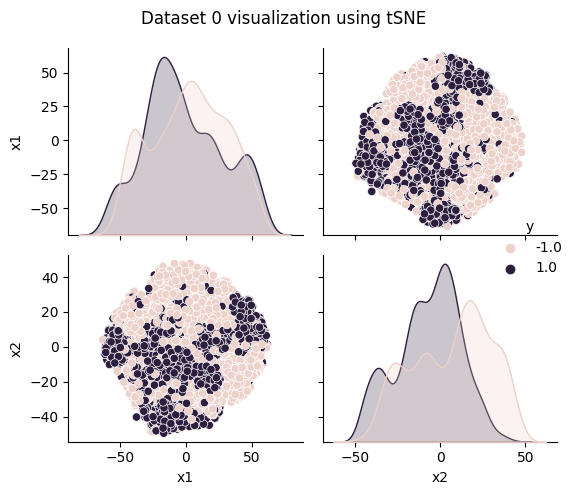

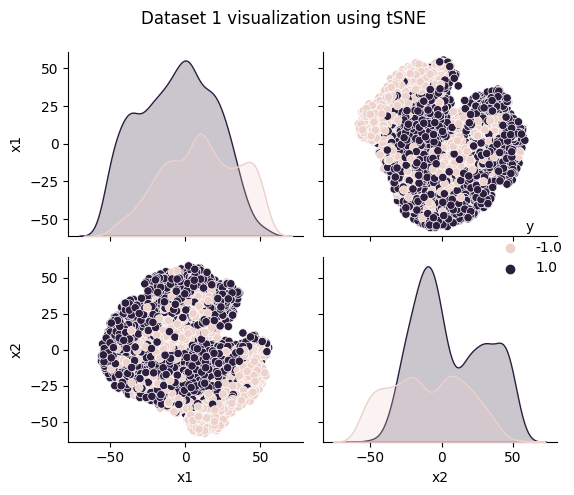

In [63]:
from sklearn.manifold import TSNE

def visualize_datasets(data):
    for i, (X, y) in enumerate(data):
        reduced_X = TSNE().fit_transform(X)
        df = pd.DataFrame(np.column_stack([reduced_X, y]), columns=['x1', 'x2', 'y'])
        g = sns.pairplot(df, hue='y')
        g.figure.suptitle(f'Dataset {i} visualization using tSNE')
        g.figure.tight_layout()

visualize_datasets(data)

<br></br>
## Part 1 - GBRT

In [316]:
from sklearn.tree import DecisionTreeRegressor

class GBRT:
    def __init__(self, alpha=0.1, T=100, max_depth=2) -> None:
        self._T = T
        self._alpha = alpha
        self._max_depth = max_depth
        self._trees = None
        
    def fit(self, X, y):
        self._trees = []
        t = y.astype(float)
        for _ in range(self._T):  
            h = DecisionTreeRegressor(max_depth=self._max_depth)
            h.fit(X, t)
            self._trees.append(h)
            t -= self._alpha * h.predict(X)

    def _H(self, X):
        y_hat = np.zeros(X.shape[0])
        for h in self._trees:
            y_hat += self._alpha * h.predict(X)
        return y_hat
    
    def predict(self, X):
        y_hat = self._H(X)
        pred = np.ones_like(y_hat)
        pred[y_hat < 0] = -1
        return pred
    
    def score(self, X , y):
        pred = self.predict(X)
        return (y == pred).sum() / y.shape[0]

In [317]:
gbrt = GBRT(T=200)
gbrt.fit(datasets[0].X_train, datasets[0].y_train)
gbrt.score(datasets[0].X_train, datasets[0].y_train)

0.8614285714285714

In [346]:
def run_GBRT_expriment():
    results = pd.DataFrame(columns=['dataset', 'T', 'alpha', 'max_depth', 'accuracy'])
    best_model = None
    for i, dataset in enumerate(datasets):
        for T in [10, 50, 100, 200]:
            for alpha in [1, 0.5, 0.1]:
                for max_depth in range(1, 3):
                    gbrt = GBRT(alpha=alpha, T=T, max_depth=max_depth)
                    gbrt.fit(dataset.X_train, dataset.y_train)
                    accuracy = gbrt.score(dataset.X_test, dataset.y_test)
                    results.loc[len(results)] = [int(i), T, alpha, max_depth, accuracy]
                    
                    if best_model is None or accuracy > best_model['accuracy']:
                        best_model = {'model': gbrt, 'accuracy': accuracy}
    
    return results, best_model

In [347]:
results, best_model = run_GBRT_expriment()

In [ ]:
def print_model(model):
    print(f'Best model: T={model["model"]._T}, alpha={model["model"]._alpha}, max_depth={model["model"]._max_depth}, accuracy={model["accuracy"]}')

print_model(best_model)

Best model: T=200, alpha=0.5, max_depth=2, accuracy=0.8976
